In [1]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
# Simple Convolutional Autoencoder
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import math
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from model import *
from utils import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
GPU_NUM = int(torch.cuda.device_count())
print(GPU_NUM)

4


In [4]:
# Set Hyperparameters

task_num = 4
in_channels = 3
out_channels = 3
img_size = (64, 64)
epoch = 50
batch_size = 32
learning_rate = 0.0005

label = torch.eye(task_num, device=device)

In [5]:
train_dataset = make_dataset('/export/data/dataset/COCO/train2014/',img_size=img_size)
test_dataset = make_dataset('/export/data/dataset/COCO/val2014/',img_size=img_size)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=GPU_NUM)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=GPU_NUM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 64, 64])


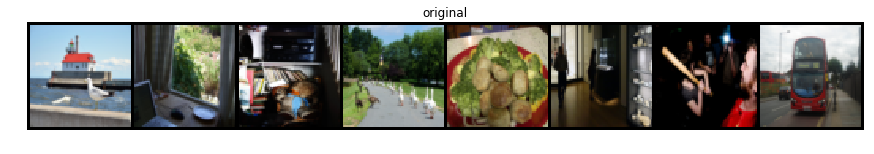

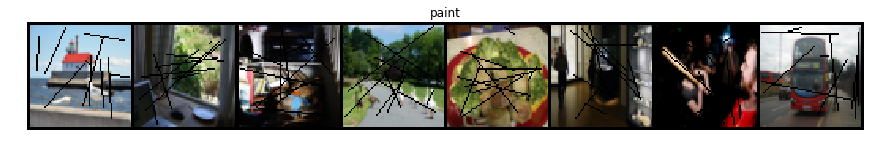

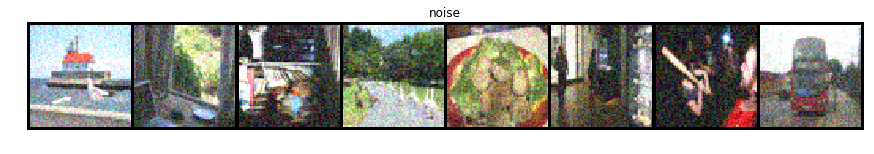

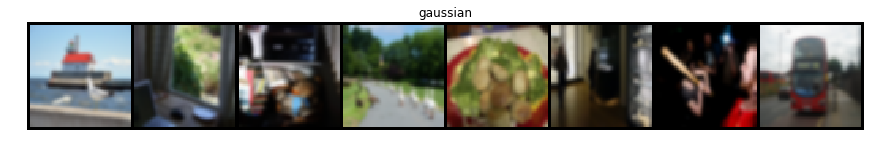

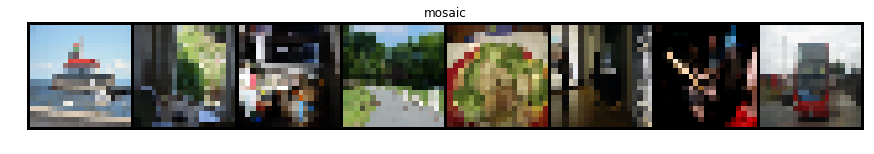

In [6]:
# 画像サンプル
samples = next(iter(test_loader))
show_img(samples[:8], 'original')
print(samples.shape)

samples_paint = paint(samples)
show_img(samples_paint[:8], 'paint')

samples_noise = noise(samples)
show_img(samples_noise[:8], 'noise')

samples_gaussian = gaussian(samples)
show_img(samples_gaussian[:8], 'gaussian')

samples_mosaic = mosaic(samples)
show_img(samples_mosaic[:8], 'mosaic')

## model

In [7]:
model = Model(in_channels=in_channels, out_channels=out_channels, dim_label=len(label)).to(device)
model = torch.nn.DataParallel(model)

## train

In [8]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(model.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [9]:
# train encoder and decoder
# save and load model
if not os.path.exists('model'):
    os.mkdir('model')
    print("directory maked")
    
load_epoch = 30
try:
    param = torch.load('./model/model_{}.pth'.format(load_epoch))
    model.load_state_dict(param)
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    i = i + load_epoch
    for j,images in enumerate(train_loader):
        
        images_paint = paint(images).to(device)
        label_paint = label[0].unsqueeze(0).repeat(images.shape[0],1)
        
        images_noise = noise(images).to(device)
        label_noise = label[1].unsqueeze(0).repeat(images.shape[0],1)
        
        images_gaussian = gaussian(images).to(device)
        label_gaussian = label[2].unsqueeze(0).repeat(images.shape[0],1)
        
        images_mosaic = mosaic(images).to(device)
        label_mosaic = label[3].unsqueeze(0).repeat(images.shape[0],1)
        
        images = images.to(device)
        
        optimizer.zero_grad()
        
        output_paint = model(images_paint, label=label_paint)
        output_noise = model(images_noise, label=label_noise)
        output_gaussian = model(images_gaussian, label=label_gaussian)
        output_mosaic = model(images_mosaic, label=label_mosaic)
        
        loss = loss_func(output_noise,images) + loss_func(output_paint,images) + loss_func(output_gaussian,images) + loss_func(output_mosaic,images)
        loss.backward()
        
        optimizer.step()
        
        if j % 500 == 0:
            print('{}epoch:{}/{},loss:{}'.format(i+1,j,len(train_loader),loss.item()))
        
    if (i+1) % 2 == 0:
        torch.save(model.state_dict(),'./model/model_{}.pth'.format(i+1))


--------model restored--------

31epoch:0/2587,loss:0.015203024260699749
31epoch:500/2587,loss:0.012328026816248894
31epoch:1000/2587,loss:0.014925289899110794
31epoch:1500/2587,loss:0.014000114053487778
31epoch:2000/2587,loss:0.014779703691601753
31epoch:2500/2587,loss:0.014520909637212753
32epoch:0/2587,loss:0.014493717812001705
32epoch:500/2587,loss:0.01410544291138649
32epoch:1000/2587,loss:0.014745626598596573
32epoch:1500/2587,loss:0.015171295031905174
32epoch:2000/2587,loss:0.013418435119092464
32epoch:2500/2587,loss:0.013740839436650276
33epoch:0/2587,loss:0.013557536527514458
33epoch:500/2587,loss:0.01359260268509388
33epoch:1000/2587,loss:0.014004301279783249
33epoch:1500/2587,loss:0.012083807960152626
33epoch:2000/2587,loss:0.013945447281002998
33epoch:2500/2587,loss:0.013189869932830334
34epoch:0/2587,loss:0.014494864270091057
34epoch:500/2587,loss:0.012524168007075787
34epoch:1000/2587,loss:0.01371802855283022
34epoch:1500/2587,loss:0.013090202584862709
34epoch:2000/2587,

KeyboardInterrupt: 